# Learning How To Explain Neural Networks: PatternNet and PatternAttribution
This notebook serves as a tool for presenting the article of the same title [[1]](#Refecences).



In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Add path to the innvestigate framework
import os
import os.path
import sys
sys.path.append(os.path.join(os.getcwd(),'inn'))

## Introduction

In many domains, such as healthcare or self driving cars, it is crucial if not legaly required to be able to explain what is going on i algorithms[[5]](#References). For deep neural networks (NN), this poses a particluarly
hard problem as neural networks are typically treated as "black boxes."

Recent work has tried to extract such explanations in various ways [[2, 3, 6-8]](#References). All approaches assumes that it is possible to decompose the condensed signal of a NN through the layers of the network and onto the input. In the following, we will see a subset of the methods.

## Overview of Explanation Approaches
**What is an explanation?**
In general, all the explanation techniques project the condensed signal of a NN through the layer and onto the input space. However, they differ in how this is done. The article defines three different ways.

**1) Functions:**  
> Explaining the function in input space corresponds to describing the operations the model uses to extract $y$ from $x$

An example of such approach could be considering the gradiend $\nabla x$, which estimates how moving along the direction of stepest ascend in input space will affect the output of the NN. This method is also known as _Sensitivity Analysis_ [[6]](#References).

In a linear model $w^\intercal x = y$, the gradient would reduce to $w$.

**2) Signals:**
> The goal is to map the condensed signal back to the input pixel space, showing what input pattern originally caused a given activation in the feature maps

Examples of such approaches is DeConvNet [[7]](#References) and Guided Backpropagation [[9]](#References). Both methods are closely related to the gradient of NNs. The difference if how ReLU non-linearities are handles. In DeConvNet, gradients are backpropagated in such a way that all ReLU are performed on the gradients instead of the input to the ReLU function. In Guided Packpropagation, the "forward" and "backward" ReLUs are combined with an "AND" operation.

**3) Attribution:**
> The goal is to identify how much the signal dimentions contribute to the output through the layers.

The classic example of this approach is Layer-Wise Relevance Propagation (LRP). The basic idea is shown below, where relevance $R_i$ is backpropagated backwards through the network. This approach distributes the prediction $nn(x)$ backward through the network using _relevance propagation rules_ [[2]](#References).

<img src="graphics/lrp-simple.png" alt="Drawing" style="width: 500px;"/>



**Comparison:**  
<img src="graphics/compare.png" alt="Comparison of explanation techniques" style="width: 90%;"/>
<img src="graphics/lrp-example.png" alt="LRP Example" style="width: 500px;"/>


The authors now claims that these methods all fail to find the signal in a simple linear layer constituting og $w^\intercal x = y$. To see why, we first need to take a step back and understand linear models a bit more.

## Understanding Linear Models


The authors presents a simple linear model where the data $x \in \mathbb{R}^{2}$ is constructed as follows. Let $y \in \mathbb{R}$ be a given set of labels and the _signal_ of the data be $s = y a_s$, where $a_s \in \mathbb{R}^2$ is the direction of the signal. Furthermore, let $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$ be noise added to the data as a _distractor_ $d = \epsilon a_d$, where $a_d \in \mathbb{R}^2$ is the direction of the distractor. Then, $x = s + d$.

Note, that using linear regression, we can find the $w$ that minimizes the mean squared error $\frac{1}{n}||Xw - y||^2_2$ of a data set $X = \left\lceil\begin{matrix}- x_1 -\\ \vdots \\ - x_n - \end{matrix}\right\rceil$ by

$$
w = (X^\intercal X)^{-1} X^\intercal y = X^\dagger y
$$

Let's construct the data and find $w$.

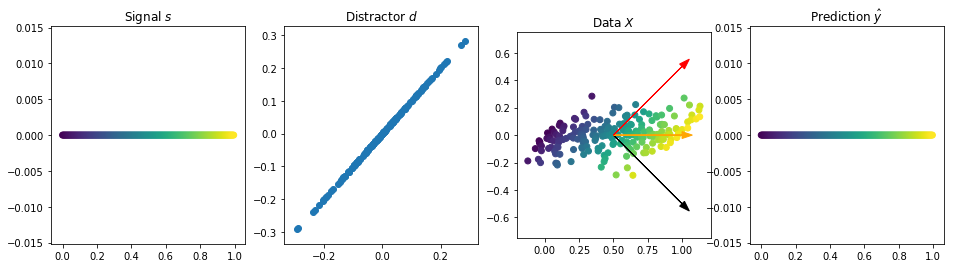

In [4]:
# Construct the data
n       = 200
y       = np.arange(n) / n
a_s     = np.array((1., 0.))
a_d     = np.array((1., 1.))
epsilon = np.random.normal(0, 0.1, size=(n,))

S       = np.outer(y, a_s)
D       = np.outer(epsilon, a_d)
X       = S + D

fig, ax = plt.subplots(1, 4, figsize=(16,4))

# Plot signal, distractor and the actual data (signal + distractor)
ax[0].set_title("Signal $s$")
ax[0].scatter(S[:,0], S[:,1], c=y)
ax[1].set_title("Distractor $d$")
ax[1].scatter(D[:,0], D[:,1])
ax[2].set_title("Data $X$")
ax[2].scatter(X[:,0], X[:,1], c=y)

# Predict y from X (Linear regression)
w       = np.linalg.pinv(X) @ y

# Draw arrows on the data plot
ax[2].set_ylim(-0.75, 0.75)
ax[2].set_aspect('equal')
ax[2].arrow(0.5,0, *(w*0.5),   head_width=.05, color='black')
ax[2].arrow(0.5,0, *(a_s*0.5), head_width=.05, color='orange')
ax[2].arrow(0.5,0, *(a_d*0.5), head_width=.05, color='red')

y_hat   = X @ w
# print("MSE: ", np.mean((y_hat - y)**2))

ax[3].set_title("Prediction $\hat y$")
ax[3].scatter(y_hat, np.zeros_like(y), c=y)


Some observations about the $X$ and $w$:
1. $w$ and $a_s$ does not point in the same direction
2. $w$ perfectly recovers $y$ but it does not reveal anything about how to extract $s$, $d$, $a_s$ or $a_d$.
3. .. Except that $w$ is optimal when it is orthogonal to the distractor, i.e. $w^\intercal d = 0$

> We want to find the signal, and hence the attribution $x \odot a_s$


### Excisting methods fail to find the signal
If we consider the estimate of the direction of the signal of each of the explanation approaches, they
all degenerate to $w$. Only Deep Taylor Decomposition [[3]](#References) actually does something different in the linear case. In particular, it does a first order taylor-expansion using a root point $\tilde x$. In that setting, $\tilde x$ serves as an estimate of the distractor $D$. However, it still does not find the actual signal of the data.

## Learning to Estimate the Signal

Since none of the methods finds the actual signal of the data, let's see if we can find a good signal extractor.  

**Problem:** we wish to find an extractor $S(x)$ such that

$$
w^\intercal S(x) = y
$$

This is, however, an illposed problem as we would choose any $u$ and associated $S(x)$:
$$
S(x) = u (w^\intercal u)^{-1}y
$$
since plugging it into the equation above, we get $w^\intercal u(w^\intercal u)^{-1} y = y$. So we need some kind
og restriction on the problem.

**Better problem:**
Instead, we introduce a quality measure $\rho$ for signal estimators and then maximize that measure. 
Assume that $w$ is a proper model and thus $w^\intercal x = y$ and that $x = s + d$ as above. Furthermore, let $\hat d = x - S(x)$ be the estimate of the distractor. Then we define $\rho$ as:

\begin{align}
\rho(S) &= 1 - \max\limits_{v} corr \left(y, v^\intercal \hat d\right)\\
        &= 1 - \max\limits_{v} corr \left(w^\intercal x, v^\intercal (x - S(x)\right)\\
        &= 1 - \max\limits_{v} \frac{v^\intercal cov[y, \hat d]}{\sigma_{v^\intercal \hat d}\sigma_{y}}
\end{align}

Note that we can minimize $\rho$ by finding $S(x)$ such that $cov[y, x - S(x)] = 0$, which (under linearity of covariance is the same as 

$$cov[y, x] - cov[y, S(x)] = 0 \Rightarrow cov[y, x] = cov[y, S(x)]$$

### Linear Signal estimator

Let's start by assuming that $S$ is linear, i.e., $S(x) = ay = aw^\intercal x$ for some direction $a$. Under this assumption, we can substitute this estimator into the equation above to get 

$$
cov[y, x] = cov[y, S(x)] \quad\Rightarrow \quad cov[y, x] = cov[y, a w^\intercal x] = a cov[y,y] = a\sigma_y^2 \quad \Rightarrow \quad a = \frac{cov[y, x]}{\sigma_y^2}
$$

Wuuuh, that was a lot of text. Let's try it on our synthetic data. 


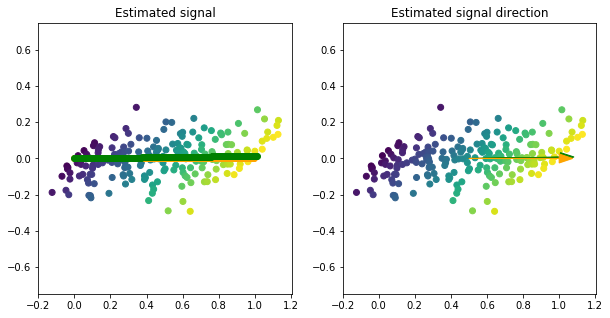

In [44]:
# Variance and Covariance of y and X
y_tmp    = np.c_[X, y]
cov      = np.cov(y_tmp.T)

cov_xy   = cov[:2,-1]
var_y    = cov[-1, -1]

a_hat    = cov_xy / var_y
S_hat    = np.outer(y_hat, a)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 29))
ax[0].set_title('Estimated signal')
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].scatter(S[:,0], S[:,1], color='orange')
ax[0].scatter(S_hat[:,0], S_hat[:,1], color='green')
ax[0].set_ylim(-0.75, 0.75)
ax[0].set_aspect('equal')

# 
ax[1].set_title("Estimated signal direction")
ax[1].scatter(X[:,0], X[:,1], c=y)

# Draw arrows on the data plot
ax[1].set_ylim(-0.75, 0.75)
ax[1].set_aspect('equal')
ax[1].arrow(0.5,0, *(a_hat*0.5), head_width=.05, color='green')
ax[1].arrow(0.5,0, *(a_s*0.5),   head_width=.05, color='orange')


### Non-linear estimator
In the article, they show empirically, that for fully connected layers, the linear signal estimator is not enough. So they do the same trick as above, but handling the positive ($w^\intercal x > 0$) and the negative ($w^\intercal x < 0$) domain separately. This is done because ReLU activation functions allows the following weights to only be optimized for the positive domain. The model that the authors suggest is the following:

$$
S_{a+-}(x) = 
\begin{cases} 
a_+ w^\intercal x \quad \text{if } w^\intercal x > 0\\
a_- w^\intercal x \quad \text{otherwise}\\
\end{cases}
$$

The solution they find for this signal extractor is the following

$$
a_+ = \frac{\mathbb{E}_+[xy] - \mathbb{E}_+[x]\mathbb{E}[y]}{w^\intercal \mathbb{E}_+[xy] - w^\intercal \mathbb{E}_+[x]\mathbb{E}[y]}
$$

Note, that in the running example, this estimator would give the same result as the one abouve.

## Experimental Results

The experimental section presents three main results. 

### 1) $\rho$ Measure

<img src="graphics/distractor.png" alt="Plot of signal quality" style="width:80%;"/>

### 2) Area Over Perturbation Curve

<img src="graphics/aopc.png" alt="Plot of signal quality" style="width:50%;"/>

### 3) Signal and Attribution 


## Trying out the beasts in practice

**Simple Network:**  
We will load a pretrained VGG16 [REF] network and create some explanations for a couple of images, using LRP [[2]](#References), DTD [[3]](#References), and PatternAttribution [[1]](#References).

**Explanations:**  
When we have trained the network, we will then produce some explanations, using different techniques.
Here, we will use the `innvestigate` framework that the authors of the PatternNet article have published.


NOT CHANNEL FIRST 


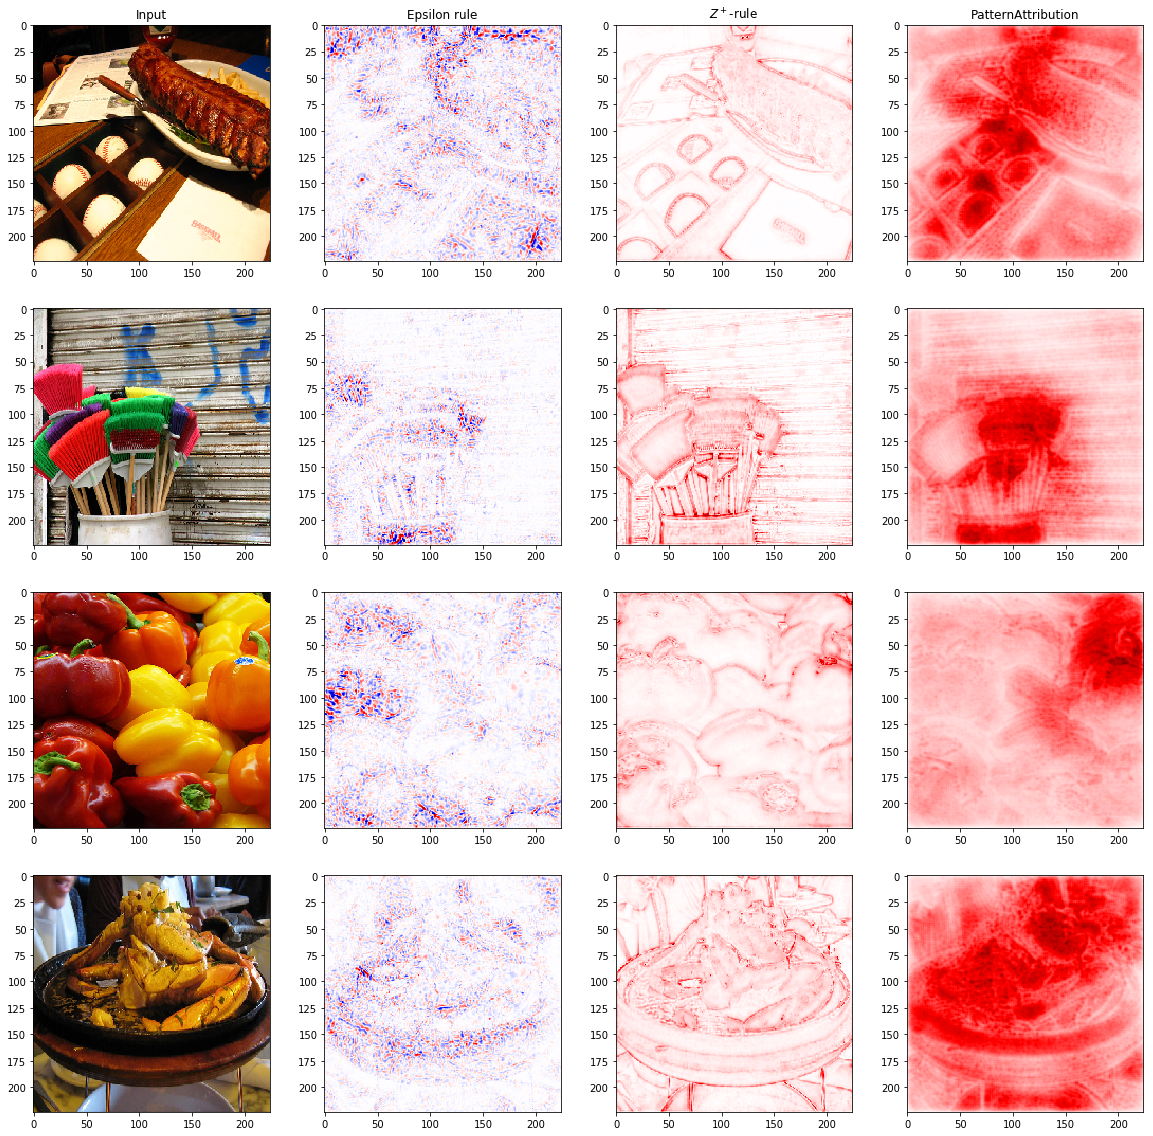

In [9]:
import sys
import os.path
import imp

import keras
import keras.backend
import keras.layers
import keras.models
from keras.models import model_from_json
import keras.utils


import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph


#### LOAD MODEL AND UTILS #### 
eutils = imp.load_source('utils', './inn/examples/utils.py')
imgnetutils = imp.load_source('utils_imagenet', './inn/examples/utils_imagenet.py')

# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, os.environ.get("NETWORKNAME", "vgg16"))
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
if channels_first:
    print("CHANNEL FIRST ")
    channel_axis = 1
else:
    print("NOT CHANNEL FIRST ")
    channel_axis = 3
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

# Load model and images
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])
if not len(images):
    raise Exception("Please download images")

# Prepare analyzers
lrp_e = innvestigate.create_analyzer("lrp.epsilon", model_wo_sm)
lrp_zp = innvestigate.create_analyzer("lrp.z_plus", model_wo_sm)
lrp_pn = innvestigate.create_analyzer("pattern.net", model_wo_sm)

# Learn signals
imgs = np.array(list(map(lambda x: x[0], images)))
lrp_pn.fit(imgs)

#### PLOTTING STUFF ####
n_imgs = 4
figs, ax = plt.subplots(n_imgs, 4, figsize=(20,20))
for i in range(n_imgs):
    # Choose a sample image and add batch axis
    image    = images[i][0][None, :, :, :]

    #Preprocess it for VGG16
    image_pp = imgnetutils.preprocess(image, net)

    # Create analysis                                        <-- Only interesting thing in plot part
    a_e      = lrp_e.analyze(image_pp)
    a_zp     = lrp_zp.analyze(image_pp)
    a_pn     = lrp_pn.analyze(image_pp) 

    # Post process images
    a_e  = imgnetutils.postprocess(a_e, color_conversion, channels_first)
    a_zp = imgnetutils.postprocess(a_zp, color_conversion, channels_first)
    a_pn = imgnetutils.postprocess(a_pn, color_conversion, channels_first)

    ax[i][0].imshow(image[0]/255)
    if i == 0: ax[i][0].set_title("Input")

    ax[i][1].imshow(imgnetutils.heatmap(a_e)[0])
    if i == 0: ax[i][1].set_title("Epsilon rule")
    
    ax[i][2].imshow(imgnetutils.heatmap(a_zp)[0])
    if i == 0: ax[i][2].set_title("$Z^+$-rule")
    
    ax[i][3].imshow(imgnetutils.heatmap(a_pn)[0])
    if i == 0: ax[i][3].set_title("PatternAttribution")


## References
[[1]](https://arxiv.org/abs/1705.05598) Kindermans, P.J., Schütt, K.T., Alber, M., Müller, K.R., Erhan, D., Kim, B. and Dähne, S., 2017. Learning how to explain neural networks: PatternNet and PatternAttribution. arXiv preprint arXiv:1705.05598.

[[2]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) Bach, S., Binder, A., Montavon, G., Klauschen, F., Müller, K.R. and Samek, W., 2015. On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation. PloS one, 10(7), p.e0130140.

[[3]](https://doi.org/10.1016/j.patcog.2016.11.008) Montavon, G., Lapuschkin, S., Binder, A., Samek, W. and Müller, K.R., 2017. Explaining nonlinear classification decisions with deep taylor decomposition. Pattern Recognition, 65, pp.211-222.

[[4]](https://arxiv.org/abs/1409.1556) Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

[[5]](https://arxiv.org/abs/1606.08813) Goodman, B. and Flaxman, S., 2016. European Union regulations on algorithmic decision-making and a" right to explanation". arXiv preprint arXiv:1606.08813.

[[6]](https://arxiv.org/abs/1312.6034) Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. Deep inside convolutional networks: Visualising image classification models and saliency maps. arXiv preprint arXiv:1312.6034.

[[7]](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53) Zeiler, M.D. and Fergus, R., 2014, September. Visualizing and understanding convolutional networks. In European conference on computer vision (pp. 818-833). Springer, Cham.

[[8]](https://arxiv.org/abs/1412.6806) Springenberg, J.T., Dosovitskiy, A., Brox, T. and Riedmiller, M., 2014. Striving for simplicity: The all convolutional net. arXiv preprint arXiv:1412.6806.

